## Setup



In [1]:
# Mounting Google Drive locally to read datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
path = "/content/drive/MyDrive/ml4health/"
print(os.listdir(path))

['msk_impact_2017_clinical_data.tsv', 'combined_encoded.csv', 'test_encoded.csv', 'train_encoded.csv', 'combined_or.csv']


In [3]:
!pip install tenseal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 10.7 MB/s eta 0:00:00


## Reading & scaling the dataset

In [4]:
import pandas as pd
train = pd.read_csv(f'{path}train_encoded.csv')
test = pd.read_csv(f'{path}test_encoded.csv')

AttributeLabels = train.columns.tolist()[:-1]

X_train = train[AttributeLabels]
X_train_encoded = pd.DataFrame(X_train, columns=AttributeLabels)
y_train_encoded = train[['Overall Survival Status']]

X_test = test[AttributeLabels]
X_test_encoded = pd.DataFrame(X_test, columns=AttributeLabels)
y_test_encoded = test[['Overall Survival Status']]

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_encoded = scaler.fit_transform(X_train_encoded)
X_train_encoded = pd.DataFrame(X_train_encoded, columns=AttributeLabels)

X_test_encoded = scaler.transform(X_test_encoded)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=AttributeLabels)

## 1-layer-NN LR functions

In [6]:
import torch
import tenseal as ts
import pandas as pd
import random
from time import time
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(0)
random.seed(0)

In [7]:
class LR(torch.nn.Module):
    def __init__(self, n_features, dropout_rate=0.5):
        super(LR, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)

    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out

def train(model, optim, criterion, x, y, epochs, x_val, y_val):
    train_losses = []
    val_losses = []

    for e in range(1, epochs + 1):
        optim.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optim.step()
        model.eval()

        # Validation step - no gradient computation
        with torch.no_grad():
            out_val = model(x_val)
            loss_val = criterion(out_val, y_val)

            train_losses.append(loss.item())
            val_losses.append(loss_val.item())

    return model, train_losses, val_losses


def accuracy(model, x, y):
    t_start = time()

    # Initialize lists to store predictions and actual labels
    predictions = []
    true_labels = []
    correct = 0

    for x_, y_ in zip(x, y):
        out = model(x_)

        if torch.abs(out - y_) < 0.5:
            correct += 1

        # Store predictions and true labels
        predictions.append(out.item())
        true_labels.append(y_.item())

    t_end = time()

    # Convert predictions and true labels to binary (0 or 1) based on 0.5 threshold
    binary_predictions = [1 if pred >= 0.5 else 0 for pred in predictions]

    # Calculate F1 score
    f1 = f1_score(true_labels, binary_predictions)

    # Calculate ROC AUC score
    roc_auc = roc_auc_score(true_labels, predictions)

    return f1, roc_auc, correct / len(x)

def split_data(X_train_encoded, y_train_encoded, train_index, val_index):
  X_train = X_train_encoded.iloc[train_index]
  y_train = y_train_encoded.iloc[train_index]

  X_val = X_train_encoded.iloc[val_index]
  y_val = y_train_encoded.iloc[val_index]

  X_train = torch.tensor(X_train.values, dtype=torch.float32)
  y_train = torch.tensor(y_train.values, dtype=torch.float32)
  X_val = torch.tensor(X_val.values, dtype=torch.float32)
  y_val = torch.tensor(y_val.values, dtype=torch.float32)

  return X_train, y_train, X_val, y_val

def get_mean_std(vals):
  mean_val= np.mean(vals)

  # Calculate the standard deviation
  std_deviation = np.std(vals)

  # Calculate the standard error
  std_error = std_deviation / np.sqrt(len(vals))

  return mean_val, std_error

### Plain Evaluation

In [8]:
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, classification_report
import numpy as np

n_features = X_train_encoded.shape[1]
model = LR(n_features)
optim = torch.optim.SGD(model.parameters(), lr=.5) # 0.5
criterion = torch.nn.BCELoss()
#criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4))

X_train, X_val, y_train, y_val = train_test_split(X_train_encoded, y_train_encoded, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_val = torch.tensor(X_val.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)

In [9]:
EPOCHS = 10

model, t_losses, v_losses = train(model, optim, criterion, X_train, y_train, EPOCHS, X_val, y_val)

print("training losses: ", t_losses)
print("validation losses: ", v_losses)

training losses:  [0.7303343415260315, 0.6837024092674255, 0.651776909828186, 0.6292763352394104, 0.6129592657089233, 0.6008350253105164, 0.591644823551178, 0.5845640897750854, 0.5790335536003113, 0.5746630430221558]
validation losses:  [0.695669412612915, 0.6654115319252014, 0.6440016627311707, 0.6283993721008301, 0.61674964427948, 0.6078805327415466, 0.6010227203369141, 0.5956524610519409, 0.5914030075073242, 0.5880109071731567]


In [10]:
f1, roc_auc, plain_accuracy = accuracy(model, torch.tensor(X_test_encoded.values, dtype=torch.float32), torch.tensor(y_test_encoded.values, dtype=torch.float32))

print(f"F1 on plain test_set: {f1}")
print(f"ROC-AUC on plain test_set: {roc_auc}")
print(f"Accuracy on plain test_set: {plain_accuracy}")

F1 on plain test_set: 0.2618473895582329
ROC-AUC on plain test_set: 0.6487032541840814
Accuracy on plain test_set: 0.7197316254955779


### Encrypted Evaluation

In [11]:
class EncryptedLR:

    def __init__(self, torch_lr):
        # TenSEAL processes lists and not torch tensors,
        # so we take out the parameters from the PyTorch model
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()

    def forward(self, enc_x):
        # We don't need to perform sigmoid as this model
        # will only be used for evaluation, and the label
        # can be deduced without applying sigmoid
        enc_out = enc_x.dot(self.weight) + self.bias
        return enc_out

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)

    def decrypt(self, context):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()

In [12]:
def encrypted_evaluation(model, enc_x_test, y_test):
    t_start = time()

    # Initialize lists to store predictions and actual labels
    predictions = []
    true_labels = []
    correct = 0

    for enc_x, y in zip(enc_x_test, y_test):
        # Encrypted evaluation
        enc_out = model(enc_x)
        # Plain comparison
        out = enc_out.decrypt()
        out = torch.tensor(out)
        out = torch.sigmoid(out)
        if torch.abs(out - y) < 0.5:
            correct += 1

        # Store predictions and true labels
        predictions.append(out.item())
        true_labels.append(y.item())

    t_end = time()

    # Convert predictions and true labels to binary (0 or 1) based on 0.5 threshold
    binary_predictions = [1 if pred >= 0.5 else 0 for pred in predictions]

    # Calculate F1 score
    f1 = f1_score(true_labels, binary_predictions)

    # Calculate ROC AUC score
    roc_auc = roc_auc_score(true_labels, predictions)

    return f1, roc_auc, correct / len(enc_x_test)

In [13]:
from sklearn.model_selection import KFold

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

### run 10 fold

# plain vals
f1_list = []
roc_auc_list = []
acc_list = []

# encrypted vals
f1_list_enc = []
roc_auc_list_enc = []
acc_list_enc = []

# encrypted weights
f1_list_enc_w = []
roc_auc_list_enc_w = []
acc_list_enc_w = []

kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Loop through each fold
for train_index, val_index in kf.split(X_train_encoded):

  ### Plain evaluation
  X_train, y_train, X_val, y_val = split_data(X_train_encoded, y_train_encoded, train_index, val_index)

  model = LR(n_features)

  model, t_losses, v_losses = train(model, optim, criterion, X_train, y_train, EPOCHS, X_val, y_val)

  f1, roc_auc, plain_accuracy = accuracy(model, torch.tensor(X_test_encoded.values,dtype=torch.float32), torch.tensor(y_test_encoded.values,dtype=torch.float32))

  f1_list.append(f1)
  roc_auc_list.append(roc_auc)
  acc_list.append(plain_accuracy)

  ### Encrypted Evaluation
  poly_mod_degree = 4096
  coeff_mod_bit_sizes = [40, 20, 40]
  # create TenSEALContext
  ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
  # scale of ciphertext to use
  ctx_eval.global_scale = 2 ** 20
  # this key is needed for doing dot-product operations
  ctx_eval.generate_galois_keys()


  t_start = time()
  enc_x_test = [ts.ckks_vector(ctx_eval, x.tolist()) for x in torch.tensor(X_test_encoded.values, dtype=torch.float32)]
  t_end = time()

  eelr = EncryptedLR(model)

  enc_f1, enc_roc_auc, enc_accuracy = encrypted_evaluation(eelr, enc_x_test, torch.tensor(y_test_encoded.values, dtype=torch.float32))

  f1_list_enc.append(enc_f1)
  roc_auc_list_enc.append(enc_roc_auc)
  acc_list_enc.append(enc_accuracy)


  eelr.encrypt(ctx_eval)
  enc_f1, enc_roc_auc, enc_accuracy = encrypted_evaluation(eelr, enc_x_test, torch.tensor(y_test_encoded.values, dtype=torch.float32))

  f1_list_enc_w.append(enc_f1)
  roc_auc_list_enc_w.append(enc_roc_auc)
  acc_list_enc_w.append(enc_accuracy)

print("================Unencrypted evaluation metrics:================\n")
print("F1 scores: ", f1_list)
f1_mean, f1_std_err = get_mean_std(f1_list)
print(f"F1 mean: {f1_mean} ± {f1_std_err}")

print("ROC-AUC scores: ", roc_auc_list)
roc_auc_mean, roc_auc_std_err = get_mean_std(roc_auc_list)
print(f"ROC-AUC mean: {roc_auc_mean} ± {roc_auc_std_err}")

print("Accuracy scores: ", acc_list)
acc_mean, acc_std_err = get_mean_std(acc_list)
print(f"Accuracy mean: {acc_mean} ± {acc_std_err}")

print("================Encrypted evaluation metrics:================\n")
print("F1 scores: ", f1_list_enc)
f1_mean_enc, f1_std_err_enc = get_mean_std(f1_list_enc)
print(f"F1 mean: {f1_mean_enc} ± {f1_std_err_enc}")

print("ROC-AUC scores: ", roc_auc_list_enc)
roc_auc_mean_enc, roc_auc_std_err_enc = get_mean_std(roc_auc_list_enc)
print(f"ROC-AUC mean: {roc_auc_mean_enc} ± {roc_auc_std_err_enc}")

print("Accuracy scores: ", acc_list_enc)
acc_mean_enc, acc_std_err_enc = get_mean_std(acc_list_enc)
print(f"Accuracy mean: {acc_mean_enc} ± {acc_std_err_enc}")

print("================Encrypted evaluation + weights metrics:================\n")
print("F1 scores: ", f1_list_enc_w)
f1_mean_enc_w, f1_std_err_enc_w = get_mean_std(f1_list_enc_w)
print(f"F1 mean: {f1_mean_enc_w} ± {f1_std_err_enc_w}")

print("ROC-AUC scores: ", roc_auc_list_enc_w)
roc_auc_mean_enc_w, roc_auc_std_err_enc_w = get_mean_std(roc_auc_list_enc_w)
print(f"ROC-AUC mean: {roc_auc_mean_enc_w} ± {roc_auc_std_err_enc_w}")

print("Accuracy scores: ", acc_list_enc_w)
acc_mean_enc_w, acc_std_err_enc_w = get_mean_std(acc_list_enc_w)
print(f"Accuracy mean: {acc_mean_enc_w} ± {acc_std_err_enc_w}")


================Unencrypted evaluation metrics:================

F1 scores:  [0.33140495867768593, 0.3881552621048419, 0.3748231966053749, 0.3395599833955999, 0.40439381611065905, 0.34205064342050645, 0.41597222222222224, 0.3637718971300783, 0.31843817787418655, 0.41303462321792256]
F1 mean: 0.3691604780759078 ± 0.01067189604533252
ROC-AUC scores:  [0.4640837455056487, 0.5511206219999635, 0.5030842200361373, 0.49230074282272634, 0.5681051632567392, 0.4830779690095089, 0.5562040298589184, 0.4805684327718056, 0.4664297056085853, 0.5766496778668029]
ROC-AUC mean: 0.5141624308736837 ± 0.013202131183020327
Accuracy scores:  [0.5065568770966759, 0.5336992985666361, 0.46081122293382126, 0.5147910948459896, 0.5535224153705398, 0.5166209210125038, 0.48703873132052455, 0.4794144556267155, 0.5208905154010369, 0.5605367490088442]
Accuracy mean: 0.5133882281183287 ± 0.00947338391175671
================Encrypted evaluation metrics:================

F1 scores:  [0.4073364358061867, 0.3842687423187218

## Plotting

In [14]:
f1_ = [f1_mean, f1_mean_enc, f1_mean_enc_w]
f1_std = [f1_std_err,  f1_std_err_enc, f1_std_err_enc_w]

roc_ = [roc_auc_mean, roc_auc_mean_enc, roc_auc_mean_enc_w]
roc_std = [roc_auc_std_err, roc_auc_std_err_enc, roc_auc_std_err_enc_w]

acc_ = [acc_mean, acc_mean_enc, acc_mean_enc_w]
acc_std = [acc_std_err, acc_std_err_enc, acc_std_err_enc_w]

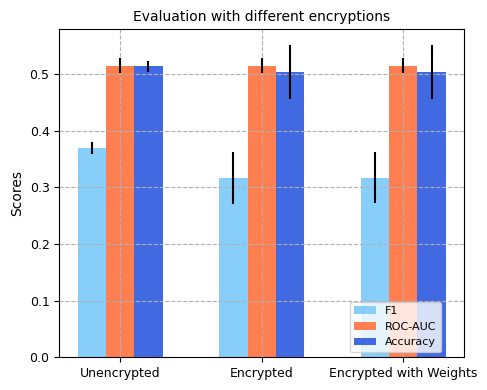

In [15]:
model_names = ['Unencrypted', 'Encrypted', 'Encrypted with Weights']
x = np.arange(len(model_names))
width = 0.2
fig, ax = plt.subplots(figsize=(5, 4))

rects1 = ax.bar(x=x - width, height=f1_, width=width, label='F1', color='lightskyblue', yerr=f1_std)
rects2 = ax.bar(x=x, height=roc_, width=width, label='ROC-AUC', color='coral', yerr=roc_std)
rects3 = ax.bar(x=x + width, height=acc_, width=width, label='Accuracy', color='royalblue', yerr=acc_std)

ax.set_ylabel('Scores', fontsize=10)
ax.set_title('Evaluation with different encryptions', fontsize=10)
ax.set_xticks(x)
ax.set_xticklabels(model_names, fontsize=9)
ax.legend(loc='lower center', bbox_to_anchor=(.83, 0), fontsize=8)
ax.tick_params(axis='y', labelsize=9)
ax.grid(True, linestyle='--')
fig.tight_layout()

plt.show()

**Note:** Plots might differ slightly each run due to the noise added from encryption's precision and SGD getting stuck on local minima, which effects label assigning after decryption and horribly fails the encrypted evaluation metrics. If metrics are too much off from our example here, delete runtime and run the code again where the plot above shows the most frequent results we have observed.